In [1]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.optimization.ising import max_cut, tsp, common
from qiskit.aqua.algorithms import VQE, ExactEigensolver, QAOA
from qiskit.aqua.components.optimizers import SPSA, ADAM
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from qiskit.qasm import pi

from docplex.mp.model import Model
from qiskit.optimization.ising import docplex

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log
from qiskit import IBMQ
provider = IBMQ.load_account()

### Max Cut

In [13]:
w = np.zeros([6,6])
for i in range(5):
    w[i, i+1] = 1
    w[i+1, i] = 1
w[0,5] = 1
w[5,0] = 1
w #ajacency matrix

array([[0., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1., 0.]])

In [14]:
qubitOp, offset = max_cut.get_operator(w)# get the qubit operator given the graph
algo_input = EnergyInput(qubitOp)

In [5]:
seed = 10598

spsa = SPSA(max_trials=300)#optimizer
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')#constructor
vqe = VQE(qubitOp, ry, spsa)#solver

backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)
print('solution:', common.sample_most_likely(result['eigvecs'][0]))

solution: [1. 0. 0. 1. 0.]


In [6]:
x = common.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

energy: -1.4999730761631862
time: 10.527269124984741
max-cut objective: -3.999973076163186
solution: [0. 1. 1. 0. 1.]
solution objective: 4.0


In [14]:
qubitOp, offset = max_cut.get_operator(w)# get the qubit operator given the graph
algo_input = EnergyInput(qubitOp)

adam = ADAM(maxiter=1000)#optimizer
qaoa = QAOA(qubitOp, adam)#QAOA solver

backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
result = qaoa.run(quantum_instance)

In [ ]:
print('solution:', common.sample_most_likely(result['eigvecs'][0]))

In [34]:
class circuits:
    def __init__(self, qbits, cbits):
        self.qbits = qbits
        self.cbits = cbits
        self.circ = QuantumCircuit(qbits, cbits)
        for i in range(qbits):
            self.circ.h(i)
    
    def beta_gate(self, beta, qbit):
        self.circ.u3(2*beta, -pi/2, pi/2, qbit)
        
    def gamma_gate(self, gamma, qbit0, qbit1):
        self.circ.x(qbit1)
        self.circ.u1(-gamma/2, qbit1)
        self.circ.x(qbit1)
        self.circ.u1(-gamma/2, qbit1)
        self.circ.cnot(qbit1, qbit0)
        self.circ.x(qbit0)
        self.circ.u1(gamma/2, qbit0)
        self.circ.x(qbit0)
        self.circ.u1(-gamma/2, qbit0)
        self.circ.cnot(qbit1, qbit0)
        
    def measure(self):
        for i in range(self.qbits):
            self.circ.measure(i,i)

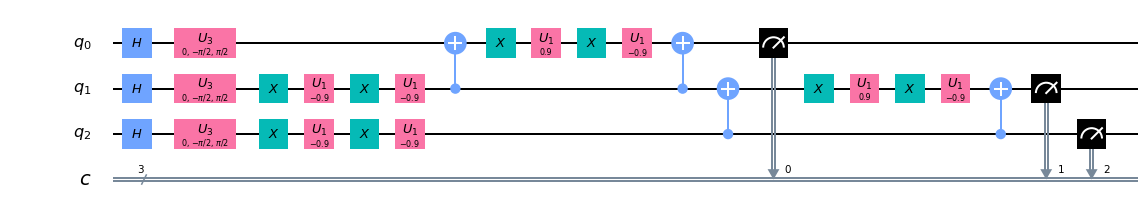

In [90]:
c = circuits(3,3)
c.beta_gate(0,0)
c.beta_gate(0,1)
c.beta_gate(0,2)
c.gamma_gate(1.8, 0, 1)
c.gamma_gate(1.8, 1, 2)

# c.beta_gate(2.094, 0)
# c.beta_gate(2.094, 1)
# c.beta_gate(2.094,2)
# c.gamma_gate(1.5, 0, 1)
# c.gamma_gate(1.5, 1, 2)

# c.beta_gate(0.094, 0)
# c.beta_gate(0.094, 1)
# c.beta_gate(0.094,2)
# c.gamma_gate(0.8, 0, 1)
# c.gamma_gate(0.8, 1, 2)

# c.beta_gate(0.094, 0)
# c.beta_gate(0.094, 1)
# c.beta_gate(0.094,2)
# c.gamma_gate(0.5, 0, 1)
# c.gamma_gate(0.5, 1, 2)

c.measure()
c.circ.draw()

In [91]:
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(c.circ, backend_sim, shots=1024)

# Grab the results from the job.
result_sim = job_sim.result()
counts = result_sim.get_counts(c.circ)
print(counts)

{'000': 128, '001': 123, '011': 125, '100': 131, '110': 138, '101': 128, '111': 127, '010': 124}


### k-max-colorable-subgrapo